In [1]:
# sdkvm

In [6]:
import pandas as pd
import numpy as np
import joblib
import lightgbm as lgbm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,classification_report
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [35]:
train_df = pd.read_csv(".././Training-Testing Dataset/Training Data (RWS Oversampling).csv")
test_df = pd.read_csv(".././Training-Testing Dataset/Testing Data (Representative).csv")
target_col = "target"

X_train = train_df.drop(columns=[target_col])
X_test = test_df.drop(columns=[target_col])

y_train = train_df[target_col]
y_test  = test_df[target_col]

print(y_train.value_counts())
categorical_columns = [col for col in X_train.columns if X_train[col].dtype == 'object']

for col in categorical_columns:
    X_train[col] = X_train[col].astype("category")
    X_test[col] = X_test[col].astype("category")

#LGBM only accepts numerical data in the target columns
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

train_set = lgbm.Dataset(X_train,label=y_train,categorical_feature=categorical_columns)
test_set = lgbm.Dataset(X_test,label=y_test,categorical_feature=categorical_columns)


target
Medium_Yes    4492
Low_No        4492
Medium_No     4492
High_No       4492
Low_Yes       4492
High_Yes      4492
Name: count, dtype: int64


In [36]:
for i, cls in enumerate(le.classes_):
    print(f"{i} → {cls}")

0 → High_No
1 → High_Yes
2 → Low_No
3 → Low_Yes
4 → Medium_No
5 → Medium_Yes


In [37]:
print(len(set(y_train)))

6


In [38]:
params = {
    'objective':'multiclass',
    'num_class':len(set(y_train)),
    'metric':'multi_logloss',
    'learning_rate':0.09,
    'num_leaves':170,
    'max_depth':-1,
    'verbose':-1
}

model = lgbm.train(params,train_set,valid_sets=[test_set],num_boost_round=500)

In [39]:
# Predict
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)  # for multiclass
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84       672
           1       0.68      0.99      0.81        76
           2       0.76      0.85      0.80       455
           3       0.63      1.00      0.77        47
           4       0.95      0.80      0.87      1123
           5       0.61      0.99      0.76       127

    accuracy                           0.83      2500
   macro avg       0.75      0.91      0.81      2500
weighted avg       0.86      0.83      0.84      2500



In [40]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
le = LabelEncoder()
y_encoded = le.fit_transform(y_test)   # Now all labels become 0,1,2,3,4,5

np.bincount(y_encoded)
print("Test class counts:", np.bincount(y_encoded))
cm = confusion_matrix(y_test, y_pred_classes)
print("Confusion matrix:\n", cm)
# Medium_No     1123
# High_No        672
# Low_No         455
# Medium_Yes     127
# High_Yes        76
# Low_Yes         47

Test class counts: [ 672   76  455   47 1123  127]
Confusion matrix:
 [[555  14  40   4  33  26]
 [  0  75   0   1   0   0]
 [ 22   7 386   9  14  17]
 [  0   0   0  47   0   0]
 [ 78  13  83  14 898  37]
 [  0   1   0   0   0 126]]


In [41]:
joblib.dump(model,r"C:\Users\Administrator\OneDrive\Desktop\FYP-MODELS\lightGBM_model.pkl")

['C:\\Users\\Administrator\\OneDrive\\Desktop\\FYP-MODELS\\lightGBM_model.pkl']

In [4]:
model = joblib.load(r"D:\FinalYearProject\Matrimony_Matchmaker\notebooks\Model-LightGBM\lightGBM_model.pkl")

In [43]:
test_df = pd.read_csv(r"D:\FinalYearProject\Matrimony_Matchmaker\notebooks\Training-Testing Dataset\Testing Data (Representative).csv")

target_col = "target"   

X_test = test_df.drop(columns=[target_col])

print(X_test.columns)
y_test  = test_df[target_col]

print(y_test.value_counts())

for col in categorical_columns:
    X_test[col] = X_test[col].astype("category")

y_test = le.fit_transform(y_test)

Index(['Age_at_Marriage', 'Gender', 'Education_Level', 'Caste_Match',
       'Religion', 'Urban_Rural', 'Income_Level', 'Spouse_Working',
       'Inter-Caste', 'Inter-Religion'],
      dtype='object')
target
Medium_No     1123
High_No        672
Low_No         455
Medium_Yes     127
High_Yes        76
Low_Yes         47
Name: count, dtype: int64


In [44]:
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)  # for multiclass
print("Accuracy:", accuracy_score(y_test, y_pred_classes))
print(classification_report(y_test, y_pred_classes))

Accuracy: 0.8348
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       672
           1       0.68      0.99      0.81        76
           2       0.76      0.85      0.80       455
           3       0.63      1.00      0.77        47
           4       0.95      0.80      0.87      1123
           5       0.61      0.99      0.76       127

    accuracy                           0.83      2500
   macro avg       0.75      0.91      0.81      2500
weighted avg       0.86      0.83      0.84      2500



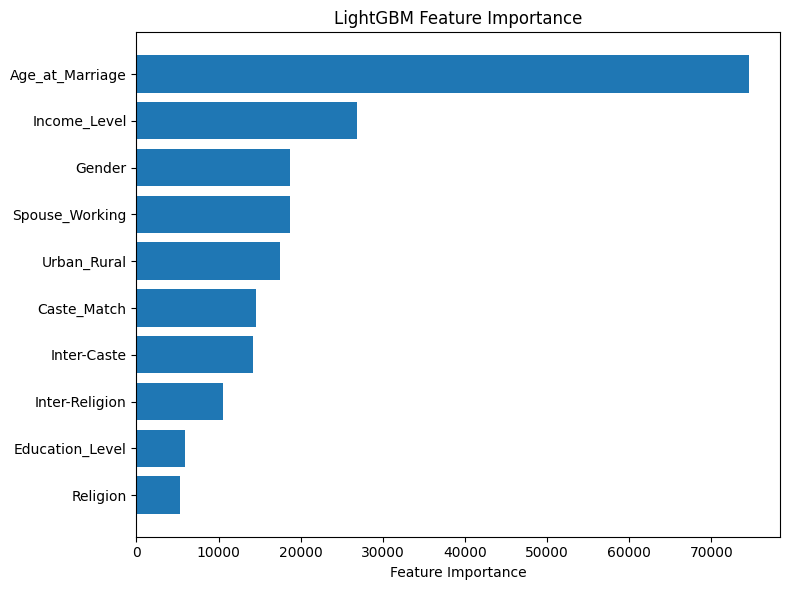

In [12]:
importances = model.feature_importance()
indices = np.argsort(importances)
feature_names = model.feature_name() 
plt.figure(figsize=(8,6))
plt.barh(range(len(importances)), importances[indices])
plt.yticks(range(len(importances)), np.array(feature_names)[indices])
plt.xlabel("Feature Importance")
plt.title("LightGBM Feature Importance")
plt.tight_layout()
plt.savefig("LightGBM Feature Importance.png", dpi=300, bbox_inches='tight')
plt.show()